In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv("patient_clinical_treatment_data.csv")

In [15]:
df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])

In [16]:
print(df.head())

   patient_id diagnosis_date            disease_type disease_stage  \
0           1     2020-05-10           Heart Disease       Stage I   
1           2     2021-07-18                    COPD       Stage I   
2           3     2021-02-04  Diabetes Complications      Stage IV   
3           4     2020-12-31             Lung Cancer      Stage IV   
4           5     2022-06-27          Kidney Disease      Stage II   

  family_history genetic_risk  hypertension  asthma  cirrhosis  other_cancer  \
0             No          Low             0       0          0             1   
1            Yes         High             1       1          1             1   
2             No       Medium             1       0          0             0   
3            Yes       Medium             0       0          1             0   
4            Yes          Low             0       0          0             0   

    treatment_type  medication_count  hospitalization_days  followup_visits  \
0  Medication Only 

In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   patient_id              11500 non-null  int64         
 1   diagnosis_date          11500 non-null  datetime64[ns]
 2   disease_type            11500 non-null  object        
 3   disease_stage           11500 non-null  object        
 4   family_history          11500 non-null  object        
 5   genetic_risk            11500 non-null  object        
 6   hypertension            11500 non-null  int64         
 7   asthma                  11500 non-null  int64         
 8   cirrhosis               11500 non-null  int64         
 9   other_cancer            11500 non-null  int64         
 10  treatment_type          11500 non-null  object        
 11  medication_count        11500 non-null  int64         
 12  hospitalization_days    11500 non-null  int64 

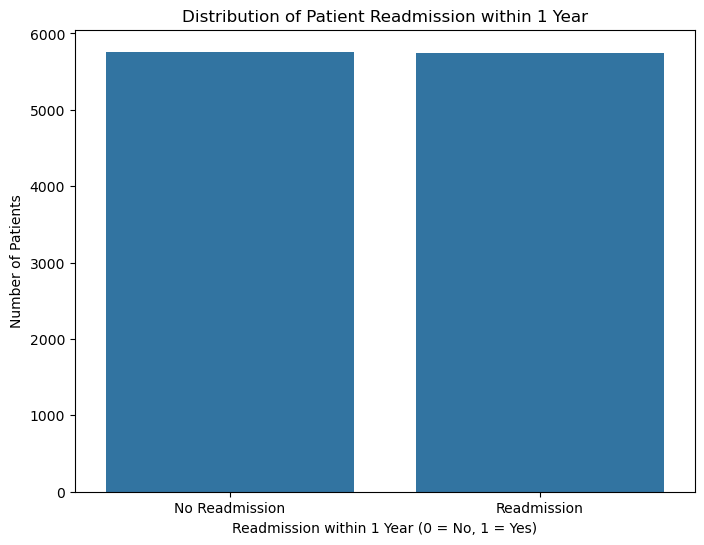

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='readmission_within_1yr', data=df)
plt.title('Distribution of Patient Readmission within 1 Year')
plt.xlabel('Readmission within 1 Year (0 = No, 1 = Yes)')
plt.ylabel('Number of Patients')
plt.xticks([0, 1], ['No Readmission', 'Readmission'])
plt.show()

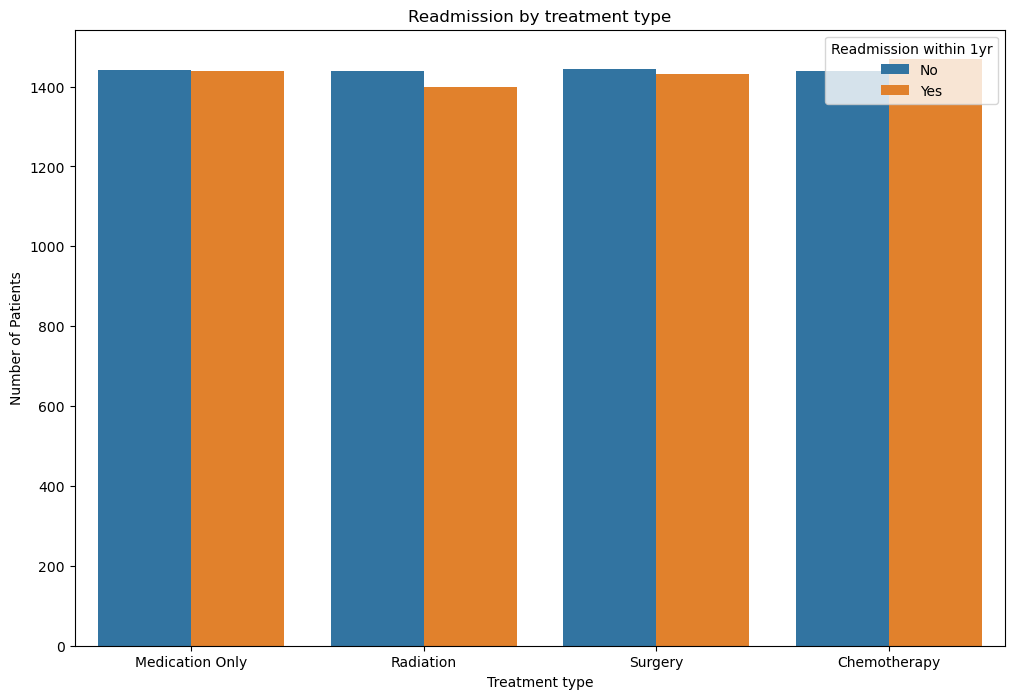

In [20]:
plt.figure(figsize=(12, 8))
sns.countplot(x='treatment_type', hue='readmission_within_1yr', data=df)
plt.title('Readmission by treatment type')
plt.xlabel('Treatment type')
plt.ylabel('Number of Patients')
plt.legend(title='Readmission within 1yr', labels=['No', 'Yes'])
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [45]:
X = df.drop(['patient_id', 'diagnosis_date', 'readmission_within_1yr', 'survived', 'followup_required'], axis=1)
y = df['readmission_within_1yr']

nominal_features = ['disease_type', 'family_history', 'genetic_risk', 'treatment_type']
ordinal_features = ['disease_stage']

disease_stage_order = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
ordinal_encoder = OrdinalEncoder(categories=[disease_stage_order])

preprocessor = ColumnTransformer(transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), nominal_features),('ordinal', ordinal_encoder, ordinal_features)],
                                 remainder='passthrough')

X_encoded = preprocessor.fit_transform(X)

print("Shape of the encoded features:", X_encoded.shape)

Shape of the encoded features: (11500, 25)


In [47]:
from sklearn.linear_model import LogisticRegression

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


In [60]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.4952


In [61]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1150
           1       0.50      0.49      0.49      1150

    accuracy                           0.50      2300
   macro avg       0.50      0.50      0.50      2300
weighted avg       0.50      0.50      0.50      2300



In [73]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'])

today = pd.to_datetime('2023-01-01')
df['days_since_diagnosis'] = (today - df['diagnosis_date']).dt.days

df['diagnosis_month'] = df['diagnosis_date'].dt.month

df['bmi'] = df['post_treatment_weight'] / (1.75 ** 2)
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, float('inf')],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

X = df.drop(['patient_id', 'diagnosis_date', 'readmission_within_1yr', 'survived', 'followup_required', 'bmi'], axis=1)
Y = df['readmission_within_1yr']

nominal_features = ['disease_type', 'family_history', 'genetic_risk', 'treatment_type', 'bmi_category']
ordinal_features = ['disease_stage']
disease_stage_order = ['Stage I', 'Stage II', 'Stage III', 'Stage IV']
ordinal_encoder = OrdinalEncoder(categories=[disease_stage_order])

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('ordinal', OrdinalEncoder(categories=[disease_stage_order]), ordinal_features)],
    remainder='passthrough')

X_encoded = preprocessor.fit_transform(X)

print("New features created and data re-encoded successfully.")
print(f"New shape of features: {X_encoded.shape}")

New features created and data re-encoded successfully.
New shape of features: (11500, 31)


In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nRandom Forest Model Accuracy: {accuracy_rf:.4f}")

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Model Accuracy: 0.4922

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      1150
           1       0.49      0.45      0.47      1150

    accuracy                           0.49      2300
   macro avg       0.49      0.49      0.49      2300
weighted avg       0.49      0.49      0.49      2300

